# 그래프 신경망 주제 분류기

여기서는 그래프 신경망을 기반으로 하는 주제 분류 모델을 구축하는 데 중점을 둘 것이다.

특히 다음 주제를 다룬다.

* 그래프 신경망 모델에서 노드 특징으로 사용될 말뭉치의 TF-IDF 표현을 생성
* 그래프 신경망 모델을 구축, 학습하고 문서 분류를 위한 최상의 임계값 식별
* 진정한 귀납적 접근 방식에 따라 샘플 외 테스트에서 모델의 성능을 테스트

**참고: 이 노트북은 01_자연어처리_그래프_생성(01_nlp_graph_creation) 노트북 이후에만 실행할 수 있다. 첫 번째 노트북에서 계산된 결과 중 일부가 여기에서 재사용되기 때문이다.**

### 데이터셋 불러오기

In [1]:
import nltk 

In [2]:
import numpy as np
import pandas as pd
import networkx as nx

In [3]:
corpus = pd.read_pickle("corpus.p")

In [4]:
corpus.head()

,clean_text,label,language,parsed
id,,,,
test/14826,ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...,[trade],en,"(ASIAN, EXPORTERS, FEAR, DAMAGE, FROM, U.S.-JA..."
test/14828,CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...,[grain],en,"(CHINA, DAILY, SAYS, VERMIN, EAT, 7, -, 12, PC..."
test/14829,JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...,"[crude, nat-gas]",en,"(JAPAN, TO, REVISE, LONG, -, TERM, ENERGY, DEM..."
test/14832,THAI TRADE DEFICIT WIDENS IN FIRST QUARTER Th...,"[corn, grain, rice, rubber, sugar, tin, trade]",en,"(THAI, TRADE, DEFICIT, WIDENS, IN, FIRST, QUAR..."
test/14833,INDONESIA SEES CPO PRICE RISING SHARPLY Indon...,"[palm-oil, veg-oil]",en,"(INDONESIA, SEES, CPO, PRICE, RISING, SHARPLY,..."


In [5]:
from collections import Counter
topics = Counter([label for document_labels in corpus["label"] for label in document_labels]).most_common(10)

In [6]:
topics

[('earn', 3964),
 ('acq', 2369),
 ('money-fx', 717),
 ('grain', 582),
 ('crude', 578),
 ('trade', 485),
 ('interest', 478),
 ('ship', 286),
 ('wheat', 283),
 ('corn', 237)]

In [7]:
topicsList = [topic[0] for topic in topics]
topicsSet = set(topicsList)
dataset = corpus[corpus["label"].apply(lambda x: len(topicsSet.intersection(x))>0)]

In [8]:
def get_labels(corpus, topicsList=topicsList):
    return corpus["label"].apply(
        lambda labels: pd.Series({label: 1 for label in labels}).reindex(topicsList).fillna(0)
    )[topicsList]

In [9]:
labels = get_labels(dataset)

In [10]:
labels.head()

,earn,acq,money-fx,grain,crude,trade,interest,ship,wheat,corn
id,,,,,,,,,,
test/14826,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
test/14828,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
test/14829,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
test/14832,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
test/14839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [11]:
def get_features(corpus):
    return corpus["parsed"]

In [12]:
def get_features_and_labels(corpus):
    return get_features(corpus), get_labels(corpus)

In [13]:
def train_test_split(corpus):
    train_idx = [idx for idx in corpus.index if "training/" in idx]
    test_idx = [idx for idx in corpus.index if "test/" in idx]
    return corpus.loc[train_idx], corpus.loc[test_idx]

In [14]:
train, test = train_test_split(dataset)

In [15]:
def my_spacy_tokenizer(pos_filter=["NOUN", "VERB", "PROPN"]):
    def tokenizer(doc):
        return [token.lemma_ for token in doc if (pos_filter is None) or (token.pos_ in pos_filter)] 
    return tokenizer

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
cntVectorizer = TfidfVectorizer(
    analyzer=my_spacy_tokenizer(),
    max_df = 0.25, min_df = 2, max_features = 10000
)

In [18]:
trainFeatures, _ = get_features_and_labels(train)
testFeatures, _ = get_features_and_labels(test)


In [19]:
trainedTransformed = cntVectorizer.fit_transform(trainFeatures)
testTransformed = cntVectorizer.transform(testFeatures)

In [20]:
features = pd.concat([
    pd.DataFrame.sparse.from_spmatrix(trainedTransformed, index=trainFeatures.index), 
    pd.DataFrame.sparse.from_spmatrix(testTransformed, index=testFeatures.index)
])

In [21]:
features.shape

(9034, 10000)

그래프 생성

In [22]:
import stellargraph as sg
from stellargraph import StellarGraph, IndexedArray
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model

In [23]:
edges = pd.read_pickle("bipartiteEdges.p")

In [24]:
entityTypes = {entity: ith for ith, entity in enumerate(edges["type"].unique())}

In [25]:
entityTypes

{'keywords': 0, 'GPE': 1, 'ORG': 2, 'PERSON': 3}

In [26]:
documentFeatures = features.loc[set(corpus.index).intersection(features.index)] #.assign(document=1, entity=0)

C:\Users\K\AppData\Local\Temp\ipykernel_2228\3397702276.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  documentFeatures = features.loc[set(corpus.index).intersection(features.index)] #.assign(document=1, entity=0)


In [27]:
documentFeatures.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
id,,,,,,,,,,,,,,,,,,,,,
training/3890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
training/11683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
test/17822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
training/146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
training/10530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
entities = edges.groupby(["target", "type"])["source"].count().groupby(level=0).apply(
    lambda s: s.droplevel(0).reindex(entityTypes.keys()).fillna(0)
).unstack(level=1)

In [29]:
entityFeatures = (entities.T / entities.sum(axis=1)).T.assign(document=0, entity=1)

In [30]:
nodes = {"entity": entityFeatures, 
         "document": documentFeatures}

In [31]:
stellarGraph = StellarGraph(nodes, 
                            edges[edges["source"].isin(documentFeatures.index)], 
                            edge_type_column="type")

In [32]:
print(stellarGraph.info())

StellarGraph: Undirected multigraph
 Nodes: 24026, Edges: 86837

 Node types:
  entity: [14992]
    Features: float32 vector, length 6
    Edge types: entity-GPE->document, entity-ORG->document, entity-PERSON->document, entity-keywords->document
  document: [9034]
    Features: float32 vector, length 10000
    Edge types: document-GPE->entity, document-ORG->entity, document-PERSON->entity, document-keywords->entity

 Edge types:
    document-keywords->entity: [78826]
        Weights: range=[0.0827011, 1], mean=0.258494, std=0.0898927
        Features: none
    document-ORG->entity: [4129]
        Weights: range=[2, 22], mean=3.24122, std=2.30508
        Features: none
    document-GPE->entity: [2943]
        Weights: range=[2, 25], mean=3.25926, std=2.07008
        Features: none
    document-PERSON->entity: [939]
        Weights: range=[2, 14], mean=2.97444, std=1.65956
        Features: none


In [33]:
from stellargraph.data import EdgeSplitter

In [34]:
splitter = EdgeSplitter(stellarGraph)

In [35]:
graphTest, samplesTest, labelsTest = splitter.train_test_split(p=0.2)

** Sampled 17367 positive and 17367 negative edges. **


In [36]:
print(stellarGraph.info())

StellarGraph: Undirected multigraph
 Nodes: 24026, Edges: 86837

 Node types:
  entity: [14992]
    Features: float32 vector, length 6
    Edge types: entity-GPE->document, entity-ORG->document, entity-PERSON->document, entity-keywords->document
  document: [9034]
    Features: float32 vector, length 10000
    Edge types: document-GPE->entity, document-ORG->entity, document-PERSON->entity, document-keywords->entity

 Edge types:
    document-keywords->entity: [78826]
        Weights: range=[0.0827011, 1], mean=0.258494, std=0.0898927
        Features: none
    document-ORG->entity: [4129]
        Weights: range=[2, 22], mean=3.24122, std=2.30508
        Features: none
    document-GPE->entity: [2943]
        Weights: range=[2, 25], mean=3.25926, std=2.07008
        Features: none
    document-PERSON->entity: [939]
        Weights: range=[2, 14], mean=2.97444, std=1.65956
        Features: none


In [37]:
print(graphTest.info())

StellarGraph: Undirected multigraph
 Nodes: 24026, Edges: 69470

 Node types:
  entity: [14992]
    Features: float32 vector, length 6
    Edge types: entity-GPE->document, entity-ORG->document, entity-PERSON->document, entity-keywords->document
  document: [9034]
    Features: float32 vector, length 10000
    Edge types: document-GPE->entity, document-ORG->entity, document-PERSON->entity, document-keywords->entity

 Edge types:
    document-keywords->entity: [63034]
        Weights: range=[0.0827011, 1], mean=0.258492, std=0.0898578
        Features: none
    document-ORG->entity: [3319]
        Weights: range=[2, 21], mean=3.24646, std=2.31997
        Features: none
    document-GPE->entity: [2362]
        Weights: range=[2, 19], mean=3.26164, std=2.05023
        Features: none
    document-PERSON->entity: [755]
        Weights: range=[2, 14], mean=2.9457, std=1.68736
        Features: none


## 주제 분류 모델 생성

학습, 검증, 테스트 셋으로 데이터 분리

In [38]:
targets = labels.reindex(documentFeatures.index).fillna(0)
#documentFeatures.drop(["entity", "document"], axis=1)

In [39]:
targets.head()

,earn,acq,money-fx,grain,crude,trade,interest,ship,wheat,corn
id,,,,,,,,,,
training/3890,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
training/11683,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
test/17822,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
training/146,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
training/10530,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [40]:
def train_test_split(corpus):
    graphIndex = [index for index in corpus.index]
    
    train_idx = [idx for idx in graphIndex if "training/" in idx]
    test_idx = [idx for idx in graphIndex if "test/" in idx]
    return corpus.loc[train_idx], corpus.loc[test_idx]

In [41]:
sampled, hold_out = train_test_split(targets)

In [42]:
allNeighbors = np.unique([n for node in sampled.index for n in stellarGraph.neighbors(node)])

In [43]:
subgraph = stellarGraph.subgraph(set(sampled.index).union(allNeighbors))

In [44]:
print(subgraph.info())

StellarGraph: Undirected multigraph
 Nodes: 16953, Edges: 62460

 Node types:
  entity: [10464]
    Features: float32 vector, length 6
    Edge types: entity-GPE->document, entity-ORG->document, entity-PERSON->document, entity-keywords->document
  document: [6489]
    Features: float32 vector, length 10000
    Edge types: document-GPE->entity, document-ORG->entity, document-PERSON->entity, document-keywords->entity

 Edge types:
    document-keywords->entity: [56653]
        Weights: range=[0.0918226, 1], mean=0.257414, std=0.0888344
        Features: none
    document-ORG->entity: [3032]
        Weights: range=[2, 22], mean=3.20877, std=2.21143
        Features: none
    document-GPE->entity: [2104]
        Weights: range=[2, 25], mean=3.25808, std=2.08119
        Features: none
    document-PERSON->entity: [671]
        Weights: range=[2, 14], mean=2.97615, std=1.66958
        Features: none


In [45]:
from sklearn.model_selection import train_test_split

train, leftOut = train_test_split(
    sampled,
    train_size=0.1,
    test_size=None,
    random_state=42,
)

validation, test = train_test_split(
    leftOut, train_size=0.2, test_size=None, random_state=100,
)

In [46]:
validation = validation[validation.sum(axis=1) > 0]
test = test[test.sum(axis=1) > 0]

In [47]:
print(f"Validation: {validation.shape}")
print(f"Test: {test.shape}")

Validation: (1168, 10)
Test: (4673, 10)


### 모델 학습

모델 생성

In [48]:
batch_size = 50
num_samples = [10, 5]

In [49]:
from stellargraph.mapper import HinSAGENodeGenerator

generator = HinSAGENodeGenerator(subgraph, batch_size, num_samples, head_node_type="document")

In [50]:
from stellargraph.layer import HinSAGE

graphsage_model = HinSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

In [51]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train.shape[1], activation="sigmoid")(x_out)

In [52]:
prediction.shape

TensorShape([None, 10])

In [53]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.binary_crossentropy,
    metrics=["acc"],
)


모델 학습 시작

In [54]:
train_gen = generator.flow(train.index, train, shuffle=True)

In [55]:
val_gen = generator.flow(validation.index, validation)

In [56]:
history = model.fit(
    train_gen, epochs=50, validation_data=val_gen, verbose=1, shuffle=False
)

Epoch 1/50
13/13 [==============================] - 55s 4s/step - loss: 0.5731 - acc: 0.1975 - val_loss: 0.4873 - val_acc: 0.4572
Epoch 2/50
13/13 [==============================] - 51s 4s/step - loss: 0.4526 - acc: 0.4861 - val_loss: 0.4070 - val_acc: 0.4255
Epoch 3/50
13/13 [==============================] - 52s 4s/step - loss: 0.3825 - acc: 0.4707 - val_loss: 0.3551 - val_acc: 0.4255
Epoch 4/50
13/13 [==============================] - 51s 4s/step - loss: 0.3364 - acc: 0.4722 - val_loss: 0.3207 - val_acc: 0.4255
Epoch 5/50
13/13 [==============================] - 51s 4s/step - loss: 0.3058 - acc: 0.4861 - val_loss: 0.2954 - val_acc: 0.4349
Epoch 6/50
13/13 [==============================] - 51s 4s/step - loss: 0.2809 - acc: 0.5586 - val_loss: 0.2738 - val_acc: 0.5017
Epoch 7/50
13/13 [==============================] - 53s 4s/step - loss: 0.2592 - acc: 0.6142 - val_loss: 0.2538 - val_acc: 0.5890
Epoch 8/50
13/13 [==============================] - 75s 6s/step - loss: 0.2384 - acc: 0.68

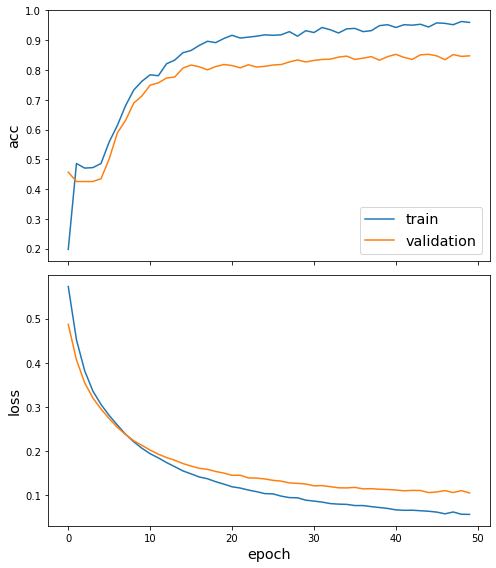

In [57]:
sg.utils.plot_history(history)

In [58]:
history = model.fit(
    train_gen, epochs=50, validation_data=val_gen, verbose=1, shuffle=False
)

Epoch 1/50
13/13 [==============================] - 60s 5s/step - loss: 0.0562 - acc: 0.9491 - val_loss: 0.1047 - val_acc: 0.8485
Epoch 2/50
13/13 [==============================] - 61s 5s/step - loss: 0.0571 - acc: 0.9645 - val_loss: 0.1066 - val_acc: 0.8373
Epoch 3/50
13/13 [==============================] - 60s 5s/step - loss: 0.0533 - acc: 0.9645 - val_loss: 0.1034 - val_acc: 0.8416
Epoch 4/50
13/13 [==============================] - 60s 5s/step - loss: 0.0534 - acc: 0.9583 - val_loss: 0.1055 - val_acc: 0.8510
Epoch 5/50
13/13 [==============================] - 60s 5s/step - loss: 0.0530 - acc: 0.9630 - val_loss: 0.1087 - val_acc: 0.8322
Epoch 6/50
13/13 [==============================] - 60s 5s/step - loss: 0.0528 - acc: 0.9599 - val_loss: 0.1047 - val_acc: 0.8527
Epoch 7/50
13/13 [==============================] - 57s 4s/step - loss: 0.0503 - acc: 0.9707 - val_loss: 0.1031 - val_acc: 0.8433
Epoch 8/50
13/13 [==============================] - 57s 4s/step - loss: 0.0488 - acc: 0.96

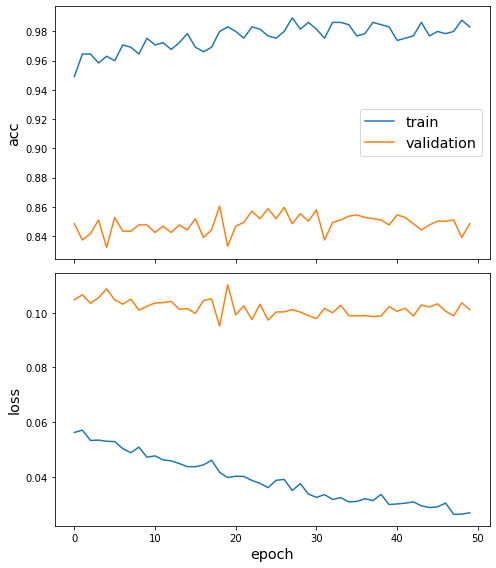

In [59]:
sg.utils.plot_history(history)

### 임계값 식별

In [60]:
test_gen = generator.flow(test.index, test)

In [61]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

94/94 [==============================] - 147s 2s/step - loss: 0.0955 - acc: 0.8671

Test Set Metrics:
	loss: 0.0955
	acc: 0.8671


In [62]:
test_predictions = pd.DataFrame(model.predict(test_gen), index=test.index, columns=test.columns)

In [63]:
test_results = pd.concat({
    "target": test, 
    "preds": test_predictions
}, axis=1)

In [64]:
from sklearn.metrics import f1_score, classification_report

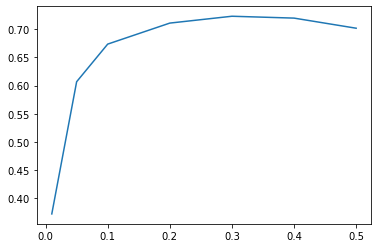

In [65]:
f1s = {}

for th in [0.01,0.05,0.1,0.2,0.3,0.4,0.5]:
    f1s[th] = f1_score(test_results["target"], 1.0*(test_results["preds"]>th), average="macro")
    
pd.Series(f1s).plot()

보다시피 임계값이 약 0.2이면 최상의 성능을 얻을 수 있다. 따라서 보고서 생성을 위해 이 값을 사용한다.

In [66]:
print(classification_report(test_results["target"], 1.0*(test_results["preds"]>0.2)))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2075
           1       0.84      0.92      0.88      1201
           2       0.52      0.92      0.67       363
           3       0.70      0.96      0.81       310
           4       0.67      0.74      0.70       286
           5       0.70      0.69      0.70       271
           6       0.64      0.79      0.70       242
           7       0.65      0.54      0.59       143
           8       0.54      0.88      0.67       159
           9       0.30      0.93      0.46       120

   micro avg       0.75      0.89      0.82      5170
   macro avg       0.65      0.83      0.71      5170
weighted avg       0.79      0.89      0.83      5170
 samples avg       0.82      0.90      0.85      5170



C:\Users\K\.conda\envs\Graph_ML_38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 귀납적 예측

이제 진정한 귀납적 예측을 수행하는 법을 알았으므로 전체 그래프를 사용할 것이며, 위에서 가장 높은 f1-score를 제공하는 임계값 0.2를 사용할 것입니다.

In [67]:
generator = HinSAGENodeGenerator(stellarGraph, batch_size, num_samples, head_node_type="document")

In [68]:
hold_out = hold_out[hold_out.sum(axis=1) > 0]

In [69]:
hold_out_gen = generator.flow(hold_out.index, hold_out)

In [70]:
hold_out_predictions = model.predict(hold_out_gen)

In [71]:
preds = pd.DataFrame(1.0*(hold_out_predictions > 0.2), index=hold_out.index, columns=hold_out.columns)

In [72]:
results = pd.concat({
    "target": hold_out, 
    "preds": preds
}, axis=1)

In [73]:
print(classification_report(results["target"], results["preds"]))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1087
           1       0.92      0.93      0.93       719
           2       0.60      0.98      0.74       179
           3       0.73      0.95      0.82       149
           4       0.72      0.90      0.80       189
           5       0.74      0.71      0.72       117
           6       0.65      0.73      0.68       131
           7       0.76      0.76      0.76        89
           8       0.57      0.97      0.72        71
           9       0.34      0.96      0.50        56

   micro avg       0.80      0.93      0.86      2787
   macro avg       0.69      0.89      0.76      2787
weighted avg       0.83      0.93      0.87      2787
 samples avg       0.86      0.93      0.88      2787



C:\Users\K\.conda\envs\Graph_ML_38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
